# 卷积神经网络（LeNet）

通过之前几节，我们学习了构建一个完整卷积神经网络的所需组件。
回想一下，之前我们将softmax回归模型（[softmax回归的从零开始实现](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/06.softmax-regression-scratch.ipynb)）和多层感知机模型（[多层感知机的从零开始实现](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/03.multilayer-perceptrons/03.mlp_scratch.ipynb)）应用于Fashion-MNIST数据集中的服装图片。
为了能够应用softmax回归和多层感知机，我们首先将每个大小为$28\times28$的图像展平为一个784维的固定长度的一维向量，然后用全连接层对其进行处理。
而现在，我们已经掌握了卷积层的处理方法，我们可以在图像中保留空间结构。
同时，用卷积层代替全连接层的另一个好处是：模型更简洁、所需的参数更少。

本节将介绍LeNet，它是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。
这个模型是由AT&T贝尔实验室的研究员**Yann LeCun**在1989年提出的（并以其命名），目的是识别图像 :cite:`LeCun.Bottou.Bengio.ea.1998`中的手写数字。
当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。

当时，LeNet取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。
LeNet被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。
时至今日，一些自动取款机仍在运行Yann LeCun和他的同事Leon Bottou在上世纪90年代写的代码呢！（太牛逼了！！！）

## LeNet

总体来看，(**LeNet（LeNet-5）由两个部分组成：**)(~~卷积编码器和全连接层密集块~~)

* 卷积编码器：由两个卷积层组成;
* 全连接层密集块：由三个全连接层组成。

该架构如 :numref:`img_lenet`所示。

![LeNet中的数据流。输入是手写数字，输出为10种可能结果的概率。](../assets/lenet.svg)
:label:`img_lenet`

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层。请注意，虽然ReLU和最大汇聚层更有效，但它们在20世纪90年代还没有出现。每个卷积层使用$5\times 5$卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。每个$2\times2$池操作（步幅2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量。

通过下面的LeNet代码，可以看出用深度学习框架实现此类模型非常简单。我们只需要实例化一个`Sequential`块并将需要的层连接在一起。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

我们对原始模型做了一点小改动，去掉了最后一层的高斯激活。除此之外，这个网络与最初的LeNet-5一致。

下面，我们将一个大小为$28 \times 28$的单通道（黑白）图像通过LeNet。通过在每一层打印输出的形状，我们可以[**检查模型**]，以确保其操作与我们期望的 :numref:`img_lenet_vert`一致。

![LeNet 的简化版。](../assets/lenet-vert.svg)
:label:`img_lenet_vert`

In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


[上述卷积神经网络LeNet每一层输出大小的计算过程](https://kimi.moonshot.cn/share/cr5n86r5cfuo6igcdm50)

请注意，在整个卷积块中，与上一层相比，每一层特征的高度和宽度都减小了。
第一个卷积层使用2个像素的填充，来补偿$5 \times 5$卷积核导致的特征减少。
相反，第二个卷积层没有填充，因此高度和宽度都减少了4个像素。
随着层叠的上升，通道的数量从输入时的1个，增加到第一个卷积层之后的6个，再到第二个卷积层之后的16个。
同时，每个汇聚层的高度和宽度都减半。最后，每个全连接层减少维数，最终输出一个维数与结果分类数相匹配的输出。

## 模型训练

现在我们已经实现了LeNet，让我们看看[**LeNet在Fashion-MNIST数据集上的表现**]。

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

虽然卷积神经网络的参数较少，但与深度的多层感知机相比，它们的计算成本仍然很高，因为每个参数都参与更多的乘法。
通过使用GPU，可以用它加快训练。

为了进行评估，我们需要[**对**] [softmax回归的从零开始实现](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/06.softmax-regression-scratch.ipynb)中描述的(**`evaluate_accuracy`函数进行轻微的修改**)。
由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中。

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval() # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将会介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

[**为了使用GPU，我们还需要一点小改动**]。
与[softmax回归的从零开始实现](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/06.softmax-regression-scratch.ipynb)中定义的`train_epoch_ch3`不同，在进行正向和反向传播之前，我们需要将每一小批量数据移动到我们指定的设备（例如GPU）上。

如下所示，训练函数`train_ch6`也类似于[softmax回归的从零开始实现](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/06.softmax-regression-scratch.ipynb)中定义的`train_ch3`。
由于我们将实现多层神经网络，因此我们将主要使用高级API。
以下训练函数假定从高级API创建的模型作为输入，并进行相应的优化。
我们使用在[数值稳定性和模型初始化](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/03.multilayer-perceptrons/09.numerical-stability-and-init.ipynb)中介绍的Xavier随机初始化模型参数。
与全连接层一样，我们使用交叉熵损失函数和小批量随机梯度下降。

In [5]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                           legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
         f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
         f'on {str(device)}')

现在，我们[**训练和评估LeNet-5模型**]。

loss 0.448, train acc 0.835, test acc 0.810
71754.1 examples/sec on cuda:0


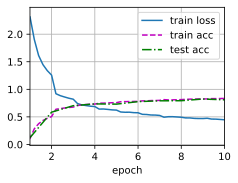

In [6]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 卷积神经网络（CNN）是一类使用卷积层的网络。
* 在卷积神经网络中，我们组合使用卷积层、非线性激活函数和汇聚层。
* 为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。
* 在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。
* LeNet是最早发布的卷积神经网络之一。

## 练习

1. 将平均汇聚层替换为最大汇聚层，会发生什么？
1. 尝试构建一个基于LeNet的更复杂的网络，以提高其准确性。
    1. 调整卷积窗口大小。
    1. 调整输出通道的数量。
    1. 调整激活函数（如ReLU）。
    1. 调整卷积层的数量。
    1. 调整全连接层的数量。
    1. 调整学习率和其他训练细节（例如，初始化和轮数）。
1. 在MNIST数据集上尝试以上改进的网络。
1. 显示不同输入（例如毛衣和外套）时，LeNet第一层和第二层的激活值。

### 练习一

1. 将平均汇聚层替换为最大汇聚层，会发生什么？

**解答：**

&emsp;&emsp;输出更大，梯度更大，训练更容易（`AlexNet`改进的方式之一）

&emsp;&emsp;`LeNet`原始代码如下：

loss 0.501, train acc 0.809, test acc 0.783
77030.8 examples/sec on cuda:0


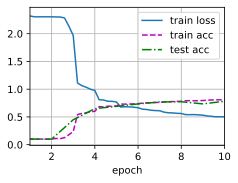

In [7]:
# 代码验证
# 导入PyTorch和d2l库
import torch
from torch import nn
from d2l import torch as d2l

# 创建一个LeNet模型，包括卷积层、池化层和全连接层
net = nn.Sequential(
    # 添加第一个卷积层，输入通道数为1，输出通道数为6，卷积核大小为5x5，padding为2
    nn.Conv2d(1, 6, kernel_size=5, padding=2), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),  
    # 添加第一个平均池化层，使用2x2的池化窗口，步长为2
    nn.AvgPool2d(kernel_size=2, stride=2), 
    # 添加第二个卷积层，输入通道数为6，输出通道数为16，卷积核大小为5x5
    nn.Conv2d(6, 16, kernel_size=5), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),  
    # 添加第二个平均池化层，使用2x2的池化窗口，步长为2
    nn.AvgPool2d(kernel_size=2, stride=2), 
    # 展平层，将多维输入展平为一维
    nn.Flatten(),  
    # 添加第一个全连接层，输入大小为16*5*5，输出大小为120
    nn.Linear(16 * 5 * 5, 120), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),  
    # 添加第二个全连接层，输入大小为120，输出大小为84
    nn.Linear(120, 84), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),  
    # 添加第三个全连接层，输入大小为84，输出大小为10（对应10个类别的分类）
    nn.Linear(84, 10))  

# 创建一个随机输入张量
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

# 遍历LeNet模型的各层并输出各层的输出形状
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期，并开始训练LeNet模型
lr, num_epochs = 0.9, 10

train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;代码验证如下：

loss 0.414, train acc 0.847, test acc 0.820
77784.9 examples/sec on cuda:0


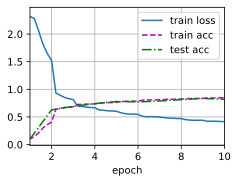

In [8]:
# 代码验证
# 导入PyTorch和d2l库
import torch
from torch import nn
from d2l import torch as d2l

# 定义一个包含最大池化层的LeNet模型
net_maxpool = nn.Sequential(
    # 添加第一个卷积层，输入通道数为1，输出通道数为6，卷积核大小为5x5，padding为2
    nn.Conv2d(1, 6, kernel_size=5, padding=2), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),  
    # 添加第一个最大池化层，使用2x2的池化窗口，步长为2
    nn.MaxPool2d(kernel_size=2, stride=2),  
    # 添加第二个卷积层，输入通道数为6，输出通道数为16，卷积核大小为5x5
    nn.Conv2d(6, 16, kernel_size=5), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),  
    # 添加第二个最大池化层，使用2x2的池化窗口，步长为2
    nn.MaxPool2d(kernel_size=2, stride=2),  
    # 展平层，将多维输入展平为一维
    nn.Flatten(),  
    # 添加第一个全连接层，输入大小为16*5*5，输出大小为120
    nn.Linear(16 * 5 * 5, 120), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),  
    # 添加第二个全连接层，输入大小为120，输出大小为84
    nn.Linear(120, 84), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),  
     # 添加第三个全连接层，输入大小为84，输出大小为10（对应10个类别的分类）
    nn.Linear(84, 10))  

# 创建一个随机输入张量
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

# 遍历LeNet模型的各层并输出各层的输出形状
for layer in net_maxpool:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net_maxpool, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习二

2. 尝试构建一个基于LeNet的更复杂的网络，以提高其准确性。
    1. 调整卷积窗口大小。
    1. 调整输出通道的数量。
    1. 调整激活函数（如ReLU）。
    1. 调整卷积层的数量。
    1. 调整全连接层的数量。
    1. 调整学习率和其他训练细节（例如，初始化和轮数）。

**第1问：**

&emsp;&emsp;修改为`nn.Conv2d(1, 6, kernel_size = 7)`

loss 0.463, train acc 0.826, test acc 0.801
67366.2 examples/sec on cuda:0


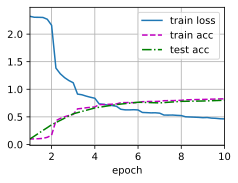

In [9]:
# 代码验证
# 导入PyTorch和d2l库
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为6。使用7x7的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 6, kernel_size=7, padding=2), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为6（上一卷积层的输出通道数），输出通道为16。使用7x7的卷积核。
    nn.Conv2d(6, 16, kernel_size=7), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*3*3（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(16 * 3 * 3, 120), 
    # 使用Sigmoid激活函数
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(84, 10))

# 打印每个层的形状
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**初步结论：** 增大卷积窗口测试准确率下降，训练速度减小。

![上述卷积神经网络LeNet每一层输出大小的计算过程](../assets/conv-layer-size.jpg)

**第2问：**

&emsp;&emsp;修改为`nn.Conv2d(1, 10, kernel_size = 5)`

loss 0.420, train acc 0.844, test acc 0.829
65288.0 examples/sec on cuda:0


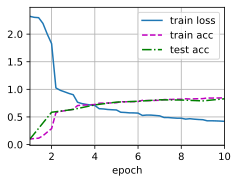

In [10]:
# 代码验证
# 导入PyTorch和d2l库
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为10。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为10（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(16 * 5 * 5, 120), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(84, 10))

# 打印每个层的形状
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**初步结论：** 增大输出通道会稍微提高一点测试准确率，训练速度也更快。

**第3问：**

&emsp;&emsp;将卷积层`nn.Sigmoid()`修改为`nn.ReLU()`

loss 0.261, train acc 0.902, test acc 0.868
65615.1 examples/sec on cuda:0


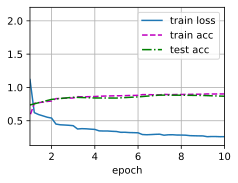

In [11]:
# 代码验证
# 导入PyTorch和d2l库
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为10。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为10（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(16 * 5 * 5, 120), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(84, 10))

# 打印每个层的形状
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**结论：** 更换激活函数为`nn.ReLU()`，loss明显更低，训练精度更高，测试精度也更高。训练速度`nn.Sigmoid()`和`nn.ReLU()`基本一样。

**第4问：**

&emsp;&emsp;添加`conv3`为`nn.Conv2d(16, 120, kernel_size = 5), ReLU()`

loss 0.259, train acc 0.902, test acc 0.872
53046.0 examples/sec on cuda:0


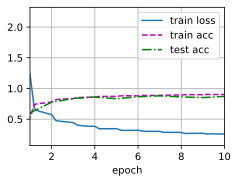

In [13]:
# 代码验证
# 导入PyTorch和d2l库
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为10。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为10（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第三个二维卷积层。输入通道为16，输出通道为120。使用5x5的卷积核。
    nn.Conv2d(16, 120, kernel_size=5),
    # 使用ReLU激活函数。
    nn.ReLU(),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 第一个全连接（线性）层。输入特征数量为120，输出特征数量为120。
    nn.Linear(120, 120), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(84, 10))

# 打印每个层的形状
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**结论：** 添加了卷积层`conv3`为`nn.Conv2d(16, 120, kernel_size = 5), ReLU()`后，测试精度提高了，训练速度也快了。

**第5问：**

&emsp;&emsp; 添加`nn.Linear(84, 20), nn.Sigmoid()`并将`nn.Linear(84, 10)`替换为`nn.Linear(20, 10)`

loss 0.308, train acc 0.888, test acc 0.836
49136.4 examples/sec on cuda:0


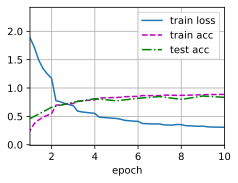

In [15]:
# 代码验证
# 导入PyTorch和d2l库
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为10。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为10（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第三个二维卷积层。输入通道为16（上一卷积层的输出通道数），输出通道为120。使用5x5的卷积核。
    nn.Conv2d(16, 120, kernel_size = 5),
    # 使用ReLU激活函数。
    nn.ReLU(),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(120, 120), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，进一步转换特征。输入特征数量为84，输出为20。
    nn.Linear(84, 20),
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第四个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(20, 10))

# 打印每个层的形状
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.9, 10

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**结论：** 添加了一个全连接层，测试精度和训练速度都是提高了一点点。

**第6问：**

&emsp;&emsp;修改为`lr, num_epochs = 0.1, 50`

loss 0.236, train acc 0.916, test acc 0.889
49178.1 examples/sec on cuda:0


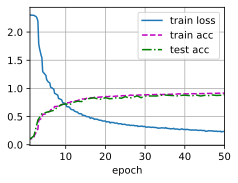

In [16]:
# 代码验证
# 导入PyTorch和d2l库
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为10。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为10（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 使用ReLU激活函数。。
    nn.ReLU(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第三个二维卷积层。输入通道为16（上一卷积层的输出通道数），输出通道为120。使用5x5的卷积核。
    nn.Conv2d(16, 120, kernel_size = 5),
    # 使用ReLU激活函数。
    nn.ReLU(),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(120, 120), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，进一步转换特征。输入特征数量为84，输出为20。
    nn.Linear(84, 20),
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第四个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(20, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.1, 50

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**结论：** 降低学习率收敛的更慢（因为要增大迭代步数），loss会更小，训练精度和测试精度都会变高。其中平均训练速度是一样的。

### 练习三

3. 在MNIST数据集上尝试以上改进的网络。

**解答：**

&emsp;&emsp;使用练习二改进后的神经网络结构：\
&emsp;&emsp;1.调整后卷积窗口的大小为 $5$ 。\
&emsp;&emsp;2.调整后输出通道的数量为 $10$。\
&emsp;&emsp;3.调整后卷积层激活函数使用`ReLU`函数。\
&emsp;&emsp;4.增加一个卷积层数量。\
&emsp;&emsp;5.增加一个全连接层数量。\
&emsp;&emsp;6.调整学习率和其他训练细节（学习率为 $0.1$，训练周期为 $50$）。

loss 0.247, train acc 0.912, test acc 0.885
49217.6 examples/sec on cuda:0


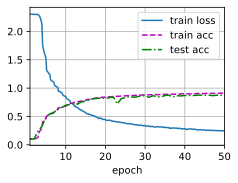

In [17]:
# 代码验证
# 导入PyTorch和d2l库
import torch
from torch import nn
from d2l import torch as d2l

# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为10。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为10（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第三个二维卷积层。输入通道为16（上一卷积层的输出通道数），输出通道为120。使用5x5的卷积核。
    nn.Conv2d(16, 120, kernel_size = 5),
    # 使用ReLU激活函数。
    nn.ReLU(),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(120, 120), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，进一步转换特征。输入特征数量为84，输出为20。
    nn.Linear(84, 20),
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第四个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(20, 10))

# 创建一个随机输入张量
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

# 遍历改进的LeNet模型的各层并输出各层的输出形状
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 加载Fashion MNIST数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')
# 设置学习率和训练周期
lr, num_epochs = 0.1, 50

# 调用train_ch6函数来在GPU上训练模型，使用你之前定义的函数
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;按照以上要求改进之后的网络在训练集和测试集上均表现出更好的效果。

### 练习四

4. 显示不同输入（例如毛衣和外套）时，LeNet第一层和第二层的激活值。

**解答：**

&emsp;&emsp;通过在所有`epoch`结束添加`d2l.show_images`展示了激活值

loss 0.244, train acc 0.912, test acc 0.884
49310.8 examples/sec on cuda:0


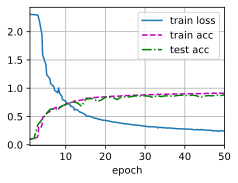

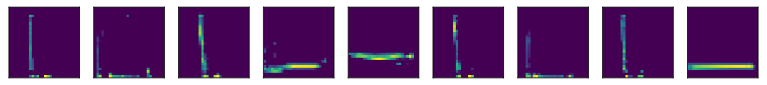

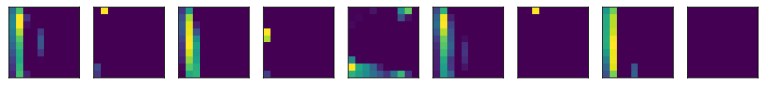

In [18]:
# 代码验证
# 导入PyTorch和d2l库
import torch
from torch import nn
from d2l import torch as d2l

# 定义一个包含多个卷积层和全连接层的LeNet模型
# 定义神经网络结构
# 创建一个序列化的神经网络模型
net = nn.Sequential(
    # 第一个二维卷积层。输入通道为1（例如，用于灰度图像），输出通道为6。使用5x5的卷积核，边缘填充2个像素。
    nn.Conv2d(1, 10, kernel_size=5, padding=2), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 最大池化层，用于降低特征维度。使用2x2的窗口大小和步长2，减少数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第二个二维卷积层。输入通道为6（上一卷积层的输出通道数），输出通道为16。使用5x5的卷积核。
    nn.Conv2d(10, 16, kernel_size=5), 
    # 使用ReLU激活函数。
    nn.ReLU(),
    # 又一个最大池化层，进一步减小数据的空间尺寸。
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 第三个二维卷积层。输入通道为16（上一卷积层的输出通道数），输出通道为120。使用5x5的卷积核。
    nn.Conv2d(16, 120, kernel_size = 5),
    # 使用ReLU激活函数。
    nn.ReLU(),
    # Flatten层，将多维度的数据展平成一维，以便传递给全连接层。
    nn.Flatten(),
    # 全连接（线性）层。输入特征数量为16*5*5（从上一层的输出尺寸计算而来），输出特征数量为120。
    nn.Linear(120, 120), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第二个全连接（线性）层，进一步转换特征。输入特征数量为120，输出为84。
    nn.Linear(120, 84), 
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第三个全连接（线性）层，进一步转换特征。输入特征数量为84，输出为20。
    nn.Linear(84, 20),
    # 使用Sigmoid激活函数。
    nn.Sigmoid(),
    # 第四个全连接（线性）层，最终输出特征数量为10，通常用于10类分类问题。
    nn.Linear(20, 10))

# 创建一个随机输入张量
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)

# 遍历LeNet模型的各层并输出各层的输出形状
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 设置训练批量大小
batch_size = 256

# 加载Fashion MNIST数据集并创建训练和测试迭代器
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 定义用于在GPU上评估模型精度的函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 定义用于训练模型的函数@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    # 定义初始化权重的函数，使用Xavier初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 对模型的所有层应用初始化权重的函数
    net.apply(init_weights)
    # 打印在哪个设备上进行训练（CPU或GPU）
    print('training on', device)
    # 将模型移动到指定的设备（CPU或GPU）
    net.to(device)
    # 定义优化器，使用随机梯度下降（SGD）优化器
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建用于绘制训练过程的动画
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    # 创建计时器和获取每个epoch的批量数
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        # 设置模型为训练模式
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # 将输入数据和标签移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 反向传播
            l.backward()
            # 更新模型参数
            optimizer.step()
            with torch.no_grad():
                # 记录训练损失、训练准确率和样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 每完成一定批量数的训练，更新动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        # 计算并记录测试集上的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))

    # 以下代码用于可视化模型中的某些层的输出
    x_first_Sigmoid_layer = net[0:2](X)[0:9, 1, :, :]
    d2l.show_images(x_first_Sigmoid_layer.reshape(9, 28, 28).cpu().detach(), 1, 9)
    x_second_Sigmoid_layer = net[0:5](X)[0:9, 1, :, :]
    d2l.show_images(x_second_Sigmoid_layer.reshape(9, 10, 10).cpu().detach(), 1, 9)

    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    # 打印训练速度（样本/秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

# 设置学习率和训练周期
lr, num_epochs = 0.1, 50

# 调用train_ch6函数来在GPU上训练模型
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

[上述选取LeNet第一层和第二层激活值的解答](https://kimi.moonshot.cn/share/cro5cd2lve9qbobo1scg)